In [1]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/DSA4212/dataset/assignment_2

Mounted at /content/drive
/content/drive/MyDrive/DSA4212/dataset/assignment_2


In [2]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import numpy as np
import pylab as plt

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy
from pandas.tseries.frequencies import unique
import tqdm

In [3]:
#reading in test and training data 
test_data=pd.read_csv('assignment_2_ratings_test.csv')
train_data=pd.read_csv('assignment_2_ratings_train.csv')

In [4]:
#functions that are used to encode the data 

def encode_column(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

def encode_column_dict(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id

# This is basically to apply the encode_column function on our columns of choice
def encode_df(data):
    anime_ids, data['anime_id'], num_anime = encode_column(data['anime_id'])
    user_ids, data['user_id'], num_users = encode_column(data['user_id'])
    return data, num_users, num_anime, user_ids, anime_ids

# Base model 

Initialising U and V from a random normal distribution where U is of the  dimension (number of unique user_ids in training data x 3) and V is of the dimension (number of unique anime_ids in training data x 3)

In [5]:
# encoding training data
train_data, num_users, num_anime, user_ids, anime_ids = encode_df(train_data)

In [6]:
#intialising training model 

ratings_list = train_data.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = np.mean( (predictions - ratings_list)**2 )
  return MSE


# Getting gradient 
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

In [7]:
#intialising U and V from random normal distribution 


# 68421 x 3 U init matrix
U_init = np.random.normal(0,1,size=(68421,3))

# 9632 x 3 matrix V init matrix
V_init = np.random.normal(0,1,size=(9632,3))

#model(U_init,V_init)

In [8]:
# Gradient descent
niter = 100
eta = 100
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


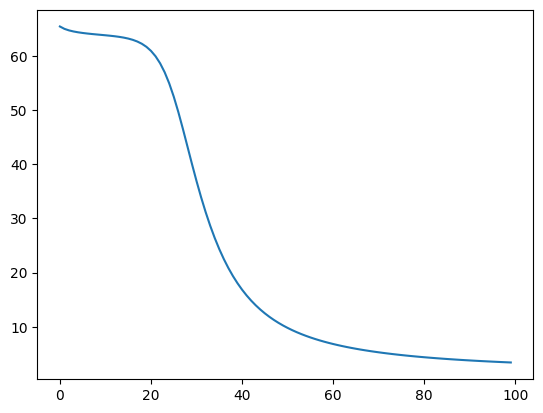

In [9]:
plt.plot(loss_traj)

In [10]:
# Encode test data with the same as training data which is just saying that we want to make sure that the same user/anime are given the 
# same index mapping in both data sets
def encode_new_data(test_data, user_ids, anime_ids):
    """ Encodes test_df with the same encoding as train_df.
    """
    # This is to check for each row entry in the test data set if it exists in the training set
    df_val_chosen = test_data['anime_id'].isin(anime_ids.keys()) & test_data['user_id'].isin(user_ids.keys())

    # Only use rows in the test data that exists for 
    test_data = test_data[df_val_chosen]
    test_data['anime_id'] =  np.array([anime_ids[x] for x in test_data['anime_id']])
    test_data['user_id'] = np.array([user_ids[x] for x in test_data['user_id']])
    return test_data

test_data = encode_new_data(test_data, user_ids, anime_ids)

<ipython-input-10-6fcc334f631a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anime_id'] =  np.array([anime_ids[x] for x in test_data['anime_id']])
<ipython-input-10-6fcc334f631a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['user_id'] = np.array([user_ids[x] for x in test_data['user_id']])


In [11]:
# finding test mse 
u_list = test_data.user_id.values
v_list = test_data.anime_id.values
ratings_list = test_data.rating.values
predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list)**2 )
MSE

Array(3.58074157, dtype=float64)

# Using genre as a factor 

In [12]:
#re read the test and training data 
test_data=pd.read_csv('assignment_2_ratings_test.csv')
train_data=pd.read_csv('assignment_2_ratings_train.csv')

In [13]:
#creating a data frame with only anime id and genre, with each genre in seperate rows 
anime_data=pd.read_csv('assignment_2_anime.csv')
anime_data.genre.fillna("None",inplace=True)
anime_data.genre=anime_data["genre"].apply(lambda x : x.split(','))
anime_data['weights']=1/anime_data.genre.apply(len) #added weights of the genre on anime id
anime_genre=anime_data.explode("genre")[['anime_id','genre','weights']] 
anime_genre.genre=anime_genre.genre.apply(lambda x : x.strip())
anime_genre

,anime_id,genre,weights
0,32281,Drama,0.250000
0,32281,Romance,0.250000
0,32281,School,0.250000
0,32281,Supernatural,0.250000
1,5114,Action,0.142857
...,...,...,...
12289,9316,Hentai,1.000000
12290,5543,Hentai,1.000000
12291,5621,Hentai,1.000000
12292,6133,Hentai,1.000000


In [14]:
#creating V matrix 
#values are the weights of each genre on each film 

V_df=anime_genre.groupby([anime_genre.anime_id, 'genre'])['weights'].first().unstack().fillna(0)

#creating a dictonary to convert anime id to the correct row index of matrix V
anime_id_V_dict=encode_column_dict(V_df.index)
V_init=np.array(V_df)


In [15]:
#addindg genre to training data and test data, 
train_data_genre=pd.merge(train_data,anime_genre,how="left",on="anime_id")
test_data_genre=pd.merge(test_data,anime_genre,how="left",on="anime_id")

In [16]:
# Using group by to display only the average rating per user per genre of anime for both test and train
train_data_grouped=train_data_genre.groupby(['user_id','genre'],as_index=False)["rating"].mean()
test_data_grouped=test_data_genre.groupby(['user_id','genre'],as_index=False)["rating"].mean()

In [17]:
#creating U matrix 
# user id are the indexs 
#values are the average rating per genre 
U_train_df=train_data_grouped.groupby([train_data_grouped.user_id, 'genre'])['rating'].first().unstack().fillna(0)


#creating a dictonary to convert user id to the correct row index of matrix U
user_id_U_train_dict=encode_column_dict(U_train_df.index)
#creating matrix U
U_init=np.array(U_train_df)


In [18]:
#changing the user id  to the encoded ones from train data set
train_data['user_id_encoded']= [user_id_U_train_dict[x] for x in train_data['user_id']]
#changing anime id to those enocded from V matrix 
train_data['anime_id_encoded']= [anime_id_V_dict[x] for x in train_data['anime_id']]


In [19]:
# encoding function for test data 
#ensures test data user and anime has the same index corressponding to the U V matrix 

def change_code_test(x,dic):
  try:
    result=dic[x]
  except KeyError:
    dic[x]=len(dic)# to add the users/anime not in training set into the U or V matrix 
    result=dic[x] 
  return result

 #adding the encoded values of users into test data 
test_data['user_id_encoded']=[change_code_test(x,user_id_U_train_dict) for x in test_data['user_id']]

 #adding the encoded values of anime into test data 
test_data['anime_id_encoded']= [change_code_test(x,anime_id_V_dict)for x in test_data['anime_id']]




In [20]:
# adding rows to U V matrix for test id that are not in train set 

#for U add a vector with value of 5 in each column for each missing user
extras_U=np.repeat(5,(max(test_data.user_id_encoded)+1-U_init.shape[0])*44)
extras_U=extras_U.reshape(max(test_data.user_id_encoded)+1-U_init.shape[0],44)
U_init=np.concatenate((U_init, extras_U))
#print(len(U_init)==len(user_id_U_train_dict.values()))


#for V add a vector with value of 1/44 in each column for each missing anime 
extras_V=np.repeat(1/V_init.shape[1],(max(test_data.anime_id_encoded)+1-V_init.shape[0])*44)
extras_V=extras_V.reshape((max(test_data.anime_id_encoded)+1-V_init.shape[0]),44)
V_init=np.concatenate((V_init, extras_V))
#print(len(V_init)==len(anime_id_V_dict))



In [21]:
## model using training data 

u_list_train=train_data.user_id_encoded.values
v_list_train=train_data.anime_id_encoded.values
ratings_list_train=train_data.rating.values

@jax.jit
def model(U, V):
  """
  U: p*r matrix 
  V: q*r matrix
  where p is number of users in training set q is number of anime in the anime data set and r is number of genres
  """
  
  predictions = jnp.sum(U[u_list_train.astype(int)]*V[v_list_train.astype(int)],axis=1)
  MSE = jnp.mean((predictions -ratings_list_train)**2 )
  return MSE

In [22]:
#find gradient 
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )
     

In [23]:

# doing Gradient descent
niter = 1000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )


100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]


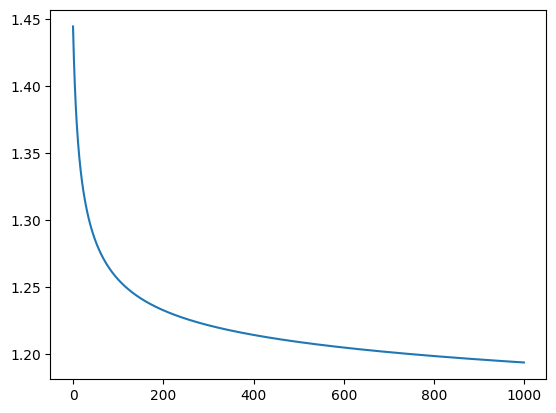

In [24]:
plt.plot(loss_traj)

In [25]:
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.86882588, dtype=float64)

# Using different optimization methods

# Gradient descent Momentum 

In [33]:
# Gradient descent
niter = 100
eta = 0.01
loss_traj = []
B = 0.9
U = np.copy(U_init)
V = np.copy(V_init)

U_tracker = [U_init]
V_tracker = [V_init]

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)
  
  # do the GD update
  U = U - eta * grad_u + B*(U-U_tracker[-1])
  V = V - eta * grad_v + B*(V-V_tracker[-1])

  U_tracker.append(U)
  V_tracker.append(V)
  # monitor the loss
  loss_traj.append( model(U,V) )



100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


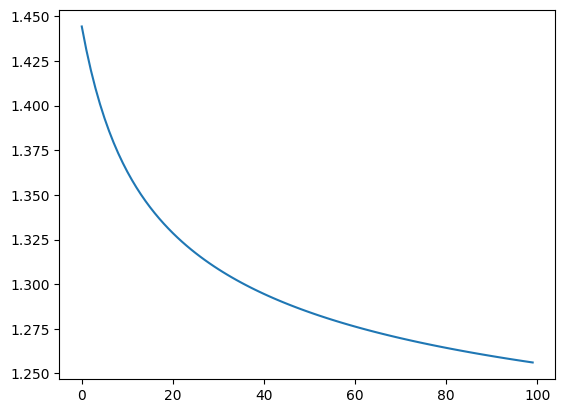

In [34]:
plt.plot(loss_traj)

In [35]:
# Test MSE using GD momentum optimization method 
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.90414079, dtype=float64)

Alternating minimization 

In [36]:
import tqdm
# doing Gradient descent
niter = 1000
eta = 0.01
loss_traj = []

U = np.copy(U_init)
V = np.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)


  # do the GD update
  U = U - eta * grad_u


  # monitor the loss
  loss_traj.append( model(U,V) )
for _ in tqdm.tqdm(range(niter)):
  # compute my gradients

  grad_v = model_grad_V(U,V)

  # do the GD update

  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

100%|██████████| 1000/1000 [00:49<00:00, 20.25it/s]


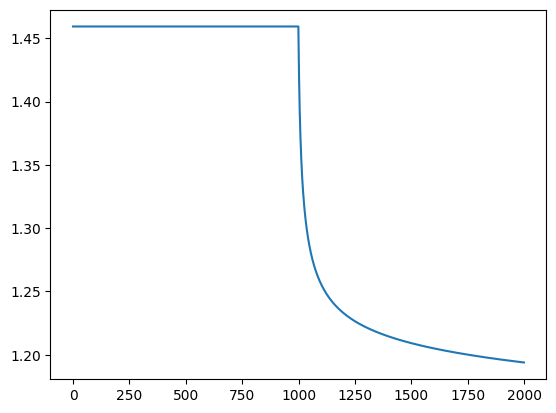

In [37]:
plt.plot(loss_traj)

In [38]:
u_list_test = test_data.user_id_encoded.values
v_list_test = test_data.anime_id_encoded.values
ratings_list_test = test_data.rating.values
predictions = jnp.sum(U[u_list_test.astype(int)] * V[v_list_test.astype(int)], axis=1)
MSE = np.mean( (predictions - ratings_list_test)**2 )
MSE

Array(1.86882766, dtype=float64)